In [1]:
import sys
from readfile import Readdat
from classifier import ThreeClassifier, plot_hyperplane
from sklearn.metrics import auc
from math import tan, pi, atan
import numpy as np
import matplotlib.pyplot as plt
import time
from fit_curve import fit_model
import matplotlib
import subprocess as sp
from scipy.optimize import curve_fit
from sklearn.svm import SVC
from cvxopt import matrix as matrix
from cvxopt import solvers
from numpy import exp
import gc

Read Data

In [2]:
class Readdat:
    ''' Read data from the raw file 
    
        self.data = x and y of the data, in list
        self.label = labels of the data, in list
        self.Xtr = x and y of trainning data
        self.ttr = labels of training data
        self.Xte = x and y of testing data
        self.tte = labels of testing data
        self.scatte() : scatter the data in different colour according to their labels
        self.classify() :　return data with spacific label
    '''
    def __init__(self, path):       
        with open(path) as file:
            linelist = file.readlines()
            lst = [line.split() for line in linelist]
            self.data = []
            self.label = []
            for line in lst:
                self.data.append([float(line[0]), float(line[1])])
                self.label.append(int(float(line[2])))
            self.data  = np.array(self.data)
            self.label = np.array(self.label)
            
            # cut dataset to training data and testing data
            size = int(len(self.data)/2)
            self.Xtr = self.data[:size]
            self.ttr = self.label[:size]
            self.Xte = self.data[size:]
            self.tte = self.label[size:]


    
    def scatter(self, data=None, label=None): 
        ''' plot the points with different colours '''
        plt.figure(figsize = (7,7))
        if data is not None and label is not None: # if a spacific class is specialised
            plt.scatter(data[:,0], data[:,1], c = label, marker = '.')
        else:
            # classify with the label from the dataset
            data0,label0 = self.classify(0)
            data1,label1 = self.classify(1)
            data2,label2 = self.classify(2)
            
            # scatter them with labels
            plt.scatter(data0[:,0], data0[:,1], c=['C0']*len(data0), marker = '.', label = 0)
            plt.scatter(data1[:,0], data1[:,1], c=['C1']*len(data1), marker = '.', label = 1)
            plt.scatter(data2[:,0], data2[:,1], c=['C2']*len(data2), marker = '.', label = 2)
            plt.legend()
            plt.show()
        
    
    
    def classify(self, lab, data = None, label = None): 
        ''' return classified data and label using the actual labels '''  
        if (data is None) and (label is None): # if data or label is not specialised, the whole data set is used
            data = self.data
            label = self.label
            
        data_classified = []
        label_classified = []
        for i in range(len(data)):
            if (label[i] == lab):
                data_classified.append(data[i])
                label_classified.append(label[i])
        return np.array(data_classified), np.array(label_classified) # return classified data and classified label

Fit Curve

In [3]:
class fit_model:
    ''' model fitting with given points 
    
        self.Boltzmann(): give Boltzmann output with specified x, sigma, b
        self.fit(): 
    '''
    def __init__(self, xlist, ylist):
        self.xlist = xlist
        self.ylist = ylist
        
    def Boltzmann(self, x, sigma, b):
        '''
        sigma stands for threshold
        b stands for sharpness
        '''
        return 1 / (1 + exp( -(x-sigma) / b))
    
    
    def fit(self, xlist, ylist, func):
        ''' Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized '''
        
        try:
            # The estimated covariance of popt
            popt, pcov = curve_fit(func, np.array(xlist), np.array(ylist))
        except:
            print("Can't fit")
            return False
        return popt
    
    
    def plot_model(self, xlist, ylist, func, title = None, graph = True, inputc='C0', predictc='C1', inputname='input', predictname='predict'):     
        ''' train the model and plot the model with input points '''
        
        popt = self.fit(xlist, ylist, func)
        
        try: # False will be not subscriptable
            popt[0]
        except:
            print('plot model problem')
            return False
        
        if graph:
            pred_y = func(np.array(np.linspace(-90,90,num=50)), popt[0], popt[1])
    #        plt.figure(figsize = (10,7))
            plt.plot(xlist, ylist, marker = 'o',c=inputc, label = inputname + 
                     '  threshold : '+str(round(popt[0],3)))
            plt.plot(np.linspace(-90,90,num=50), pred_y,c = predictc, marker = '.',
                     label = predictname+'  sharpness: '+str(round(popt[1],3)))
            plt.legend(fontsize = 12)
            if title:
                plt.title(title)
        return popt[0],  popt[1]

Path Analysis

In [4]:
class Analyse:
    '''
      analyse a file, input its path  
    
      self.visualise_data() : visualise the data with two boundaries represented by a dashed line
      self.view_predict : view data with their predicted label
      self.view_ROC_AUC() : view the ROC curves and AUC values of this dataset 
      self.view_correctness() : view the graph with the misclassified points coloured
      self.view_TPR_theta() : view TPR against theta
    '''
    
    def __init__(self, path, kernel = 'linear', gamma = 'auto', C = 1, degree =3):
        self.path = path
        
        self.kernel = kernel
        # the kernel the classifier uses(rbf, default = linear, polynomial)
        
        self.gamma = gamma
        # kernel coefficient for poly and rbf 
        
        self.C = C
        # Penalty parameter C of the error term of classifier
        
        self.degree = degree
        # degree for polynomial kernel, ignored by the others
        
        self.reader = Readdat(path)  
        # reader of the dataset
        
        self.classifier = ThreeClassifier(path, self.kernel, C = self.C, gamma = self.gamma, degree=self.degree)  
        # train a classifier for this dataset
        
        self.Xte = self.reader.Xte  
        # test data
        
        self.tte = self.reader.tte  
        # label of test data
        
        self.prediction = self.classifier.predict()  
        # the 0 row is the result of cla01
        # the 1 row is the result of cla12
        # the 2 row is the overall prediction
        # the 3 row is the original label
        
        self.svm01 = self.classifier.cla01
        self.svm12 = self.classifier.cla12
        # two svms used to identify the boundaries
        
        if kernel == 'linear':
            w01 = self.svm01.coef_[0]
            intercept01 = self.svm01.intercept_[0]
            self.k01 = -w01[0]/w01[1]
            self.b01 = - intercept01/w01[1]
            w12 = self.svm12.coef_[0]
            intercept12 = self.svm12.intercept_[0]
            self.k12 = -w12[0]/w12[1]
            self.b12 = - intercept12/w12[1]
            # the infomation of two boundaries
        
    def accuracy(self):
        return np.mean(self.prediction[2,:] == self.prediction[3,:])
    
    def visualise_data(self):
        '''
        visualise the data with two boundaries represented by a dashed line   
        '''
        
        plt.figure(figsize=(7,7))
        data0,label0 = self.reader.classify(0)
        data1,label1 = self.reader.classify(1)
        data2,label2 = self.reader.classify(2)
        
        # scatter them with labels
        plt.scatter(data0[:,0], data0[:,1], c=['C0']*len(data0), marker = '.', label = 0)
        plt.scatter(data1[:,0], data1[:,1], c=['C1']*len(data1), marker = '.', label = 1)
        plt.scatter(data2[:,0], data2[:,1], c=['C2']*len(data2), marker = '.', label = 2)
        plt.legend()
        plt.xlim(-1,2)
        plt.ylim(-1,2)
        
        if self.kernel == 'linear':
            plot_hyperplane(self.svm01, 0, 2, 'dashed')
            plot_hyperplane(self.svm12, 0, 2, 'dashed')
        plt.title('VISUALISE DATA')
        plt.show()
    # visualise the result of the dataset and the prediction 

    
    def view_predict(self):
        '''
        view data with their predicted label
        
        '''
        return self.classifier.view_predict()
    
    
    def view_data_predict(self):
        '''
        do self.visualise_data() and self.view_predict()
        
        '''  
    
        data0,label0 = self.reader.classify(0)
        data1,label1 = self.reader.classify(1)
        data2,label2 = self.reader.classify(2)
        
        # visualise data
        
        fig, axs = plt.subplots(nrows = 1, ncols = 2)
        fig.set_figheight(6)
        fig.set_figwidth(13)
        
        axs[0].scatter(data0[:,0], data0[:,1], c=['C0']*len(data0), marker = '.', label = 0)
        axs[0].scatter(data1[:,0], data1[:,1], c=['C1']*len(data1), marker = '.', label = 1)
        axs[0].scatter(data2[:,0], data2[:,1], c=['C2']*len(data2), marker = '.', label = 2)
        axs[0].legend(fontsize = 12, loc=2)
        axs[0].set_xlim(-1,2)
        axs[0].set_ylim(-1,2)
        axs[0].set_title('All data'+'  kernel: '+ self.kernel , fontsize = 15)
        
        
        # view_predict
        
        prediction = np.column_stack((ana.Xte, ana.classifier.predict()[2,:]))
        prediction_0 = prediction[np.where(prediction[:,2] == 0)]
        prediction_1 = prediction[np.where(prediction[:,2] == 1)]
        prediction_2 = prediction[np.where(prediction[:,2] == 2)]
        
        axs[1].scatter(prediction_0[:,0], prediction_0[:,1], c='C0', marker='.', label = '0')
        axs[1].scatter(prediction_1[:,0], prediction_1[:,1], c='C1', marker='.', label = '1')
        axs[1].scatter(prediction_2[:,0], prediction_2[:,1], c='C2', marker='.', label = '2')
        axs[1].legend(fontsize = 12, loc=2)
        axs[1].set_title('PREDICTION accuracy: '+str(self.accuracy())+ '   C: '+str(self.C)+'   gamma: '+str(self.gamma), fontsize = 12)
        axs[1].set_xlim(-1,2)
        axs[1].set_ylim(-1,2)
        
        return True
    
    
    def get_boundary_ROC(self, k, b, tar_lab, data, label):
        '''
        get TPR and FPR for a specific boundary, the boundary depends on the input data
        
        must be linear kernel
        
        k = slope of the boundary
        b = bias of the boundary
        tar_lab = the label of the boundary, i.e. the points above the boundary is supposed to <= tar_lab
        data = test data
        label = actual label of test data
        
        '''
        
        if self.kernel != 'linear':
            print('Not Linear Kernel')
            return False
        
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for i in range(len(data)): # compare the actual position and the label
            x = data[i][0]
            y = data[i][1]
            
            # Positive: label smaller than target, Negative: label larger than target
            if y >= (k * x + b): # points above the line or on the line means that the prediction is smaller than target
                if label[i] <= tar_lab: # the actual label is less than or equal to target
                    TP += 1
                else:
                    FP += 1
            else: # points under the line means that the prediction is larger than target
                if label[i] > tar_lab: # actual label is larger than target
                    TN += 1
                else:
                    FN += 1
        
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        
        return TPR, FPR
        # get tpr and fpr for a specific boundary
    
    

    def getTPR_FPR(self, b, tar_lab, data, label, angle=(-pi/2, pi/2)):
        '''
        return list of TPR and list FPR for a bias, the boundary will sweep through the space specified by b and angle(range)
        
        b = bias of boundary
        tar_lab = the label of the boundary, i.e. the points above the boundary is supposed to <= tar_lab
        data = test data
        label = actual label of test data
        angle = the range of changing k(default to be (-pi/2, pi/2))
        
        '''
        
        if self.kernel != 'linear':
            print('Not Linear Kernel')
            return False
        
        TPR = []
        FPR = []
        for ang in np.linspace(angle[0], angle[1], num = 100): # for each boundary, should be fixed if compare the sharpness
            
            k = tan(ang)  # transfer angle to slope
            
            k_tpr, k_fpr = self.get_boundary_ROC(k, b, tar_lab, data, label)  # get tpr and fpr for a boundary
            TPR.append(k_tpr) # TPR
            FPR.append(k_fpr) # FPR
            
        return TPR, FPR
    # return TPR and FPR list for plot and auc()
    
    
    def view_ROC_AUC(self):
        '''
        view the ROC curves and AUC values of this dataset 
        
        '''
        #  TPR and FPR
        tpr01, fpr01 = self.getTPR_FPR(self.b01, 0, self.Xte, self.tte)  # get TPR, FPR list of boundary 01
        tpr12, fpr12 = self.getTPR_FPR(self.b12, 1, self.Xte, self.tte)  # get TPR, FPR list of boundary 12
        
        
        # ROC curve
        plt.figure(figsize=(10,7))
        plt.plot(fpr01, tpr01)
        plt.plot(fpr12, tpr12)
        plt.title('ROC CURVE')
        # AUC
        auc01 = auc(fpr01, tpr01)
        auc12 = auc(fpr12, tpr12)
        print('AUC01: ' + str(auc01) + '  AUC12: ' + str(auc12))
        
        return True
        # plot ROC curves and AUCs of both boundaries
    
    
    
    def getMiscDis(self, k01, k12, data, label, b01 = 0, b12 = 0, origin = (0,0), angular = True):
        '''
        return the average distance from misclassified points to the boundary specified by k and b
        for linear classifier
        
        k = slope of the boundary
        tar_lab = the label of the boundary, i.e. the points above the boundary is supposed to <= tar_lab
        data = test data
        label = actual label of test data
        bias = bias of the boundary
        origin = angle against what origin, default to be (0,0)
        
        '''
        
        if self.kernel != 'linear':
            print('Not Linear Kernel')
            return False
        
        distance0 = []
        distance1 = []
        
        for i in range(len(data)): # compare the actual position and the label
            x = data[i][0]
            y = data[i][1]
            lab = label[i]
            rho = np.sqrt((x - origin[0])**2 + (y - origin[1])**2)
            line_y01 = k01 * x + b01  # estimated y on bound01
            line_y12 = k12 * x + b12  # estimated y on bound12
            
            # bound 01
            # if prediction and actual label are on different sides
            if (line_y01 <= y and lab > 0) or (line_y01 > y and lab <= 0) :
                
                # kx - y + b = 0
                point_dis = abs(k01 * x + (-1) * y + b01) / np.sqrt(k01**2 + (-1)**2)
                if point_dis/rho > 1 or point_dis/rho < -1:
                    print(x,y,origin,rho,point_dis,k01,b01)
                    continue
                
                # choose angular distance or raw distance
                if angular:
                    distance0.append(np.arcsin(point_dis / rho))  # get the angle distance
                else:
                    distance0.append(point_dis)  # get the raw distance
                    
                    
            # bound 12
            # if prediction and actual label are on different sides
            if (line_y12 <= y and lab > 1) or (line_y12 > y and lab <= 1) :
                
                # kx - y + b = 0
                point_dis = abs(k12 * x + (-1) * y + b12) / np.sqrt(k12**2 + (-1)**2)
                if point_dis/rho > 1 or point_dis/rho < -1:
                    print(x,y,origin,rho,point_dis,k12,b12)
                    continue
                
                # choose angular distance or raw distance
                if angular:
                    distance1.append(np.arcsin(point_dis / rho))  # get the angle distance
                else:
                    distance1.append(point_dis)  # get the raw distance
            
                    
        return np.mean(distance0), np.mean(distance1) 
    # return the average distance from misclassified points to the boundary
    
    
    
    def show_correctness(self, data):
        '''
        get correctness label of data(label compared to prediction)
        
        k = slope of the boundary
        b = bias of the boundary
        tar_lab = the label of the boundary, i.e. the points above the boundary is supposed to <= tar_lab
        data = test data
        label = actual label of test data
        '''
        
        
        cor_classified = []
        
        for i in range(len(data)): # compare the actual position and the label
            x = data[i][0]
            y = data[i][1]
            prediction = self.prediction[2,i]
            label = self.prediction[3,i]
            
            cor_classified.append([[x,y], prediction == label])
                
        return cor_classified 
    # return a list to tell which cells are correctly classified and which are not
    
    
    def view_correctness(self, title='CORRECT CLASSIFIED CELLS:  '):
        '''
        view the graph with the misclassified points coloured
        
        titile = title of the graph, default='CORRECT CLASSIFIED CELLS'
        
        '''
        
        
        corr = self.show_correctness(self.Xte) # correctness overall    
        plt.figure(figsize = (7,7))
        data_True = np.array([dat[0] for dat in corr if dat[1]==True])
        data_False = np.array([dat[0] for dat in corr if dat[1]==False])    
        plt.scatter(data_True[:, 0],data_True[:, 1],c='gray', marker='.', label = 'True')
        plt.scatter(data_False[:,0],data_False[:,1],c='#fa5fa0', marker='.', label = 'False')
        plt.legend()
        plt.xlim(-1,2)
        plt.ylim(-1,2)
        if title:
            plt.title(title+self.kernel+'  degree: '+str(self.degree))
            
        if self.kernel == 'linear':
            plot_hyperplane(self.svm01, 0, 2, 'dashed')
            plot_hyperplane(self.svm12, 0, 2, 'dashed')

        return True      
    # plot correct classified cells 
    
    
    def getTPR_theta(self, theta_list, data, label, tar_lab):
        '''
        return list of [theta, TPR], the boundary sweeps through the space based on theta_list, each of them crosses the origin
        
        best for linear kernel
        
        theta_list = thetas of the boundaries
        data = test data
        label = actual label of test data
        tar_lab = the label of the boundary, i.e. the points above the boundary is supposed to <= tar_lab
        
        '''
        
        TPR = []
        k_list = np.array([tan(theta/180 * pi) for theta in theta_list])
        
        for k in k_list: # for each boundary, should be fixed if compare the sharpness
            TP = 0
            FN = 0
            for i in range(len(data)): # compare the actual position and the label
                x = data[i][0]
                y = data[i][1]
                
                # Positive: label smaller than target, Negative: label larger than target
                # y = k * x cross the origin
                if y >= k * x: # points above the line or on the line means that the prediction is smaller than target
                    if label[i] <= tar_lab: # the actual label is less than or equal to target
                        TP += 1
                else: # points under the line means that the prediction is larger than target
                    if label[i] <= tar_lab: # actual label is smaller than target
                        FN += 1
                        
            TPR.append(TP / (TP + FN)) # TPR
        
        
        return np.array([[theta,tpr] for theta,tpr in zip(theta_list, TPR)])
    # get theta tpr pair to view the tpr against theta
    
    
    def view_TPR_theta(self, theta_range=np.linspace(-90, 90, num = 100)):
        '''
        view TPR against Theta
        best for linear kernel
        
        theta_range =  chosen angle of boundaries
        '''
        
        plt.figure(figsize=(10,7))
        
        # for boundary 01
        tpr_theta01 = self.getTPR_theta(theta_range, self.Xte, self.tte, 0)
        plt.scatter(tpr_theta01.T[0], tpr_theta01.T[1])
        plt.axvline(x=atan(self.k01),c='#ffaa33',linestyle='--', label = 'slope_01 = '+str(round(self.k01/pi*180,3)))  # draw verticle line at arctan(k01) 
        plt.legend(prop={'size': 15})
        plt.xlabel('Theta')
        plt.ylabel('TPR')
#        plt.xticks(np.linspace(-90, 90, 7),[theta for theta in np.linspace(-90, 90, 7 )])
    
        # for boundary 12
        tpr_theta12 = self.getTPR_theta(theta_range, self.Xte, self.tte, 1)
        plt.scatter(tpr_theta12.T[0], tpr_theta12.T[1])
        plt.axvline(x=atan(self.k12),c='#ffaa33',linestyle='--', label = 'slope_12 = '+str(round(self.k12/pi*180,3)))  # draw verticle line at arctan(k01) 
        plt.legend(prop={'size': 15})
        plt.xlabel('Theta')
        plt.ylabel('TPR')
#        plt.xticks(np.linspace(-pi/2, pi/2, 7),[theta for theta in np.linspace(-90, 90, 7 )])
        
        plt.title('TPR_theta')
    
    
    
    def TPR_delta_theta(self, theta_list, cell_label = True):
        '''
        return values for probability distribution(the portion of a label in an area)
        best for linear kernel
        
        theta_list = thetas of the boundaries (-90,90)
        cell_label = if True, calculate the increasement of True points(actual label) sweep by last move, if False, calculate the False points(actual label)
        '''

        # copy to a new data set
        data = self.Xte.copy()
        label = self.tte.copy()
        
        prob_01 = []  # probability of target point (True or False) for bound01
        prob_12 = []  # probability of target point (True or False) for bound12
        
        for t in range(len(theta_list) - 1):  # for each starting angle of a boundary
            
            #  upper bound: y = tan(theta_list[t] / 180 * pi)   * x
            #  lower bound: y = tan(theta_list[t+1] / 180 * pi) * x

            count = 0  # number of point between those boundary
            tar_count_01 = 0  # number of target point between those boundary for 01
            tar_count_12 = 0  # number of target point between those boundary for 12
            remove_list = []  # the list of points(t) to remove
            
            for d in range(len(data)):  # for each data, data should have the same size to label
                x = data[d][0]
                y = data[d][1]
                lab = label[d]
                upper_bound = tan(theta_list[t+1] / 180 * pi) * x
                lower_bound = tan(theta_list[t]   / 180 * pi) * x
                
                
                
                if upper_bound >= y >= lower_bound:  # if this point is in the space
                    
                    # point in the space
                    count += 1 
                    remove_list.append(d)
                    
                    # if target_label for boundary 01
                    if (lab <= 0) == cell_label:
                        tar_count_01 += 1      
                    # if target_label for boundary 12
                    if (lab <= 1) == cell_label:
                        tar_count_12 += 1
                        
            
            # collect the result
            try:
                prob_01.append(tar_count_01/count)
            except ZeroDivisionError:
                prob_01.append(1-cell_label)
            try:
                prob_12.append(tar_count_12/count) 
            except ZeroDivisionError:
                prob_12.append(1-cell_label)
            
            # remove points in older spaces
            data = np.delete(data, remove_list, axis = 0)
            label = np.delete(label, remove_list)
        
        return prob_01, prob_12



    def view_TPR_delta_theta(self, cell_label = True, sample = 50, title = None):
        '''
        return values for probability distribution
        best for linear kernel
        
        theta_list = thetas of the boundaries (-90,90)
        cell_label = if True, calculate the increasement of True points(actual label) sweep by last move, if False, calculate the False points(actual label)
        sample = how many samples are chosen to form the curve
        title = title of graph
        '''
        
        plt.figure(figsize=(10,7))
        c01,c12 = self.TPR_delta_theta(np.linspace(-30, 90, num = sample+1), cell_label=cell_label)
        plt.plot(c01, label = 'boundary 01')
        plt.plot(c12, label = 'boundary 12')
        if title:
            plt.title(title, fontsize=15)
        plt.legend(fontsize=12)
        plt.xticks(np.linspace(1, sample, num=10), [round(tick) for tick in np.linspace(-30, 90, num=10)])
        plt.show()
        
    
    def view_boltzmann_model(self, graph = True, sample = 50, title = None):
        ''' 
        get the TPR against the angle
        
        '''
        
        xticks   = np.linspace(-30, 90, num = sample)    # windows no
        xticks_b = np.linspace(-30, 90, num = sample+1)  # boundary no
        
        c01, c12 = self.TPR_delta_theta(xticks_b)
        try:
            fit_01 = fit_model(xticks, c01)
            sigma01, b01 = fit_01.plot_model(xticks, c01, fit_01.Boltzmann, graph = False, inputc='C0', predictc='C2',
                              inputname='Boundary 01', predictname='Model       01')
            fit_12 = fit_model(xticks, c12)
            sigma12, b12 = fit_12.plot_model(xticks, c12, fit_12.Boltzmann, graph = False, inputc='C1', predictc='C3',
                              inputname='Boundary 12', predictname='Model       12')
        except:
            print(len(c01),len(xticks),len(c12),len(xticks))
            return
        
        pred_y01 = fit_01.Boltzmann(xticks, sigma01, b01)
        pred_y12 = fit_12.Boltzmann(xticks, sigma12, b12)
        
        plt.figure(figsize=(10,7))
        plt.plot(xticks, c01, 'o', label = 'boundary 01', c = 'C0')
        plt.plot(xticks, c12, 'o', label = 'boundary 12', c = 'C3')
        plt.plot(xticks, pred_y01, label = 'model 01', c = 'C2')
        plt.plot(xticks, pred_y12, label = 'model 12', c = 'C1')
        plt.xticks(np.linspace(-30, 90, num = 13))
        plt.xlabel('angle')
        plt.ylabel('TPR')
        plt.legend()
        if title:
            plt.title(title, fontsize = 15)
        
        return True

Sharpness Measurement

In [5]:
class SharpnessMeasurement:
    ''' sharpness measured by different metrics through a dataset 
    
        self.b_of_Boltzmann(): visualise sharpness by the b of Boltzmann distribution 
        self.AUC(): visualise sharpness by the AUC(area under the (ROC)curve)
        self.distance(): visualise sharpness by the angular distance or the raw distance. 
                         angular distance/raw distance are controlled by angular=True/False
        self.distance_against_Boltzmann(): visualise the comparison of distance measuremance and Boltzmann measuremance
                                           (show both angular distance and raw distance)
    '''
    def __init__(self, path):
        self.path = path
        
        
    def b_of_Boltzmann(self, graph = True, title = 'no title', xlist = [round(0.5 - 0.05 * i, 2) for i in range(10)]):
        '''
        show b of Boltzmann
        
        graph = show the graph or not
        title = title
        xlist = default to be linear x
        
        '''
        gen = Paths(prefix = self.path)
        blist = [] # use b in Boltzmann as sharpness
        
        while(1):
            
            # generate path
            try:
                path = next(gen)
            except StopIteration:
                break
            try:
                
                ana = Analyse(path)
            except:
                continue
            
            print(path[-16:])
            
            # c01, c12 are TPR data for boundary_01 and boundary_12
            # fit the model
            c01,c12 = ana.TPR_delta_theta(np.linspace(-90,90, num = 51), cell_label=True)
            
            xlist = [round(i,2) for i in np.linspace(-90,90,num=50)]
            
            #plt.figure(figsize = (10,7))
            fit_01 = fit_model(xlist, c01)
            sigma01, b01 = fit_01.plot_model(xlist, c01, fit_01.Boltzmann, graph = False, inputc='C0', predictc='C2',
                              inputname='Boundary 01', predictname='Model       01')
            fit_12 = fit_model(xlist, c12)
            sigma12, b12 = fit_12.plot_model(xlist, c12, fit_12.Boltzmann, graph = False, inputc='C1', predictc='C3',
                              inputname='Boundary 12', predictname='Model       12')
           # plt.title('TPR against Theta', fontsize=15)
    
            blist.append([b01, b12])
                
        # if graph is not needed, return list of b including both bounds    
        if not graph:
            return blist
                      
        del path
        del gen
        print('\n\nFinish')
        
        # devide b01 and b12
        plt.figure(figsize=(10,7))
        plt.xlabel('sharp', fontsize=12)
        plt.ylabel('b in Boltzmann') 
        blistT = np.array(blist).T
        plt.plot(blistT[0], label='b01')
        plt.plot(blistT[1], label='b12')
        plt.legend()
        plt.xticks([i*10 for i in range(10)], xlist)
        plt.title(title,fontsize=15)  
        
        
        return blist
    
    
    def AUC(self, graph = True, title = 'no title', xlist = [round(0.5 - 0.05 * i, 2) for i in range(10)]):
        ''' describe the sharpness of the document with AUC 
        
            graph = show the graph or not
            title = title of the graph
            xlist = the xlist specified for the graph
        '''
        
        gen = Paths(prefix=self.path)
        auclist = [] # use auc as sharpness
        
        while(1):
            try:
                path = next(gen)
            except:
                break
            
            ana = Analyse(path)
            TPR01,FPR01 = ana.getTPR_FPR(0, 0, ana.Xte, ana.tte, angle = (-pi/6, pi/2))
            TPR12,FPR12 = ana.getTPR_FPR(0, 1, ana.Xte, ana.tte, angle = (-pi/6, pi/2))
            auc01 = auc(FPR01, TPR01)
            auc12 = auc(FPR12, TPR12)
            
            auclist.append([auc01, auc12])
            print(path[-16:])
            
        print('\n\nFinish')
        
        # if graph is not needed, return auclist
        if not graph:
            return auclist
        
        # devide b01 and b12
        plt.figure(figsize=(10,7))
        plt.xlabel('sharp', fontsize=12)
        plt.ylabel('AUC') 
        auclistT = np.array(auclist).T
        plt.plot(auclistT[0], label='b01')
        plt.plot(auclistT[1], label='b12')
        plt.legend()
        plt.xticks([i*10 for i in range(10)], xlist)
        plt.title(title,fontsize=15)  
        
        
        return auclist
    
    
    def distance(self, graph = True, title = 'no title', xlist = [round(0.5 - 0.05 * i, 2) for i in range(10)], angular = True):
        ''' describe the sharpness of the document with angular distance or raw distance 
            
            graph = show the graph or not
            title = title of the graph
            xlist = the xlist specified for the graph
            augular = use augualr distance or raw distance
        '''
        
        gen = Paths(prefix = self.path)
        dislist = [] # angular(or raw) distance as sharpness
        
        while(1):
            
            # generate path
            try:
                path = next(gen)
            except StopIteration:
                break
            try:
                
                ana = Analyse(path)
            except:
                continue
            
            print(path[-16:])
                   
            # -------------------------- angular distance --------------------------------------
            
            # calculate the meeting point of y = k01 * x + b01 and y = k12 * x + b12 as the new origin
            ori_x = (ana.b01 - ana.b12) / (ana.k12 - ana.k01)
            ori_y = ori_x * ana.k01 + ana.b01
            
            # collect distances
            dis01, dis12= ana.getMiscDis(ana.k01, ana.k12, ana.Xte, ana.tte, ana.b01, ana.b12, origin = (ori_x, ori_y), angular=angular)    
            dislist.append([dis01, dis12])
    
        print('\n\nFinish')
    
        # visualise
        # if graph not needed, return dislist 
        if not graph:
            return dislist
        
        dislist = np.array(dislist).T
        
        plt.figure(figsize=(10,7))
        plt.xlabel('sharp', fontsize=12)
        plt.ylabel('distance') 
#        dislistT = np.array(dislist).T
        plt.plot(dislist[0], label='b01')
        plt.plot(dislist[1], label='b12')
        plt.legend()
        plt.xticks([i*10 for i in range(10)], xlist)
        plt.ylim((0,1))
        plt.title(title,fontsize=15) 
        
        return dislist
    
    
    
    def distance_against_Boltzmann(self, title = 'no title'):
        ''' show the sharpness described by distance against that by Boltzmann 
        
            graph = show the graph or not
            title = title of the graph
            xlist = the xlist specified for the graph
        '''
        
        # path generator
        gen = Paths(prefix=self.path)
        blist = [] # use b in Boltzmann as sharpness
        dislist_a = [] # angular distance as sharpness
        dislist_r = [] # raw distance as sharpness
        
        while(1):
            
            # generate path
            try:
                path = next(gen)
            except StopIteration:
                break
            try:
                
                ana = Analyse(path)
            except:
                continue
            
            print(path[-16:])
            
            
            # ---------------------------- b of Boltzmann -------------------------------------------
            
            # c01, c12 are TPR data for boundary_01 and boundary_12
            # fit the model
            c01,c12 = ana.TPR_delta_theta(np.linspace(-90,90, num = 51), cell_label=True)
            
            xlist = np.linspace(-90,90,num=50)
            
            #plt.figure(figsize = (10,7))
            fit_01 = fit_model(xlist, c01)
            sigma01, b01 = fit_01.plot_model(xlist, c01, fit_01.Boltzmann, graph = False, inputc='C0', predictc='C2',
                              inputname='Boundary 01', predictname='Model       01')
            fit_12 = fit_model(xlist, c12)
            sigma12, b12 = fit_12.plot_model(xlist, c12, fit_12.Boltzmann, graph = False, inputc='C1', predictc='C3',
                              inputname='Boundary 12', predictname='Model       12')
           # plt.title('TPR against Theta', fontsize=15)
    
            blist.append([b01, b12])
            
            
            # -------------------------- angular distance --------------------------------------
            
            # calculate the meeting point of y = k01 * x + b01 and y = k12 * x + b12 as the new origin
            ori_x = (ana.b01 - ana.b12) / (ana.k12 - ana.k01)
            ori_y = ori_x * ana.k01 + ana.b01
    #        print(ori_x, ori_y, ana.b01, ana.b12, ana.k01, ana.k12)
            
            # collect distances
            dis01_a, dis12_a = ana.getMiscDis(ana.k01, ana.k12, ana.Xte, ana.tte, ana.b01, ana.b12, origin = (ori_x, ori_y), angular=True)
            dislist_a.append([dis01_a, dis12_a])
            
            dis01_r, dis12_r = ana.getMiscDis(ana.k01, ana.k12, ana.Xte, ana.tte, ana.b01, ana.b12, origin = (ori_x, ori_y), angular=False)
            dislist_r.append([dis01_r, dis12_r])
    
        print('\n\nFinish')
        
        
        # visualise
        
        blist = np.array(blist).T
        dislist_a = np.array(dislist_a).T
        dislist_r = np.array(dislist_r).T
    
        sharp01 = np.array(sorted(np.vstack([blist[0],dislist_a[0],dislist_r[0]]).T, key=lambda x:x[0])).T
        sharp12 = np.array(sorted(np.vstack([blist[1],dislist_a[1],dislist_r[1]]).T, key=lambda x:x[0])).T
        
        
        fig, [ax0,ax1] = plt.subplots(ncols = 2, figsize=(12,5))
        fig.suptitle(title,fontsize=18)
        
        
        color = 'tab:red'
        ax0.set_xlabel('b of Boltzmann')
        ax0.set_ylabel('angular distance', color=color)
        ax0.plot(sharp01[0], sharp01[1], color=color)
        ax0.tick_params(axis='y', labelcolor=color)
        
        ax01 = ax0.twinx()  # instantiate a second axes that shares the same x-axis
        
        color = 'tab:blue'
        ax01.set_ylabel('raw distance', color=color)  # we already handled the x-label with ax1
        ax01.plot(sharp01[0], sharp01[2], color=color)
        ax01.tick_params(axis='y', labelcolor=color)
        
        ax0.set_title('Boundary 01', fontsize=12)
        
        
        color = 'tab:red'
        ax1.set_xlabel('b of Boltzmann')
        ax1.set_ylabel('angular distance', color=color)
        ax1.plot(sharp12[0], sharp12[1], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        
        
        ax11 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        
        color = 'tab:blue'
        ax11.set_ylabel('raw distance', color=color)  # we already handled the x-label with ax1
        ax11.plot(sharp12[0], sharp12[2], color=color)
        ax11.tick_params(axis='y', labelcolor=color)
        
        ax1.set_title('Boundary 12', fontsize=12)
        
        
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        
        plt.show()

Paths

In [6]:
path0 = 'D:/CytonemeSignaling/testDataSameSharpness/testDataSameSharpness/coords_00061.dat'
path1 = 'D:/CytonemeSignaling/testDataSameLocation/testDataSameLocation/coords_00041.dat'
path2 = 'D:/CytonemeSignaling/testDataNonlinearMonotonic/testDataNonlinearMonotonic/coords_00019.dat'
path3 = 'D:/CytonemeSignaling/testDataNonlinearNonMonotonic/testDataNonlinearNonMonotonic/coords_00013.dat'
path4 = 'D:/CytonemeSignaling/testDataStudySharpness_linear/SameSharpness/coords_00066.dat'

In [7]:
def Paths(prefix):    
    ''' choose one of the path set and return a generator generates one path each time '''
    
    for i in range(1, 101):
        number_code = str(i)
        while(len(number_code)<5):  number_code = '0'+number_code
        number_code = (prefix + '/coords_' + number_code + '.dat')
        yield number_code
    # yield a path in a group

make sure all above are run

In [8]:
ana = Analyse(path0) 

In [9]:
ana.accuracy()
''' the accuracy of the prediction '''

' the accuracy of the prediction '

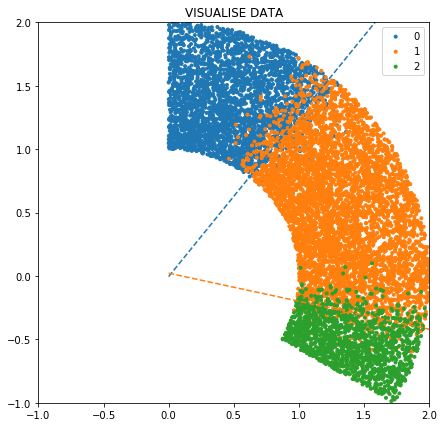

'\nvisualise the data with two boundaries represented by a dashed line   \n'

In [10]:
ana.visualise_data()
'''
visualise the data with two boundaries represented by a dashed line   
'''

'\nview data with their predicted label\n\n'

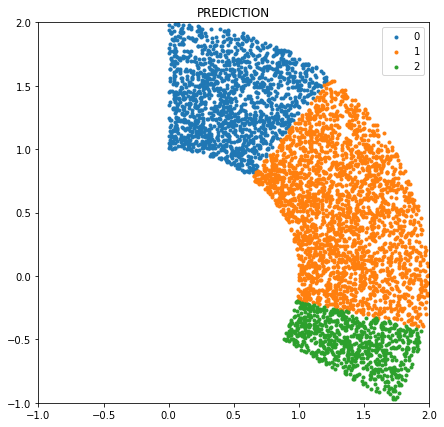

In [11]:
ana.view_predict()
'''
view data with their predicted label

'''

'\ndo self.visualise_data() and self.view_predict()\n\n'

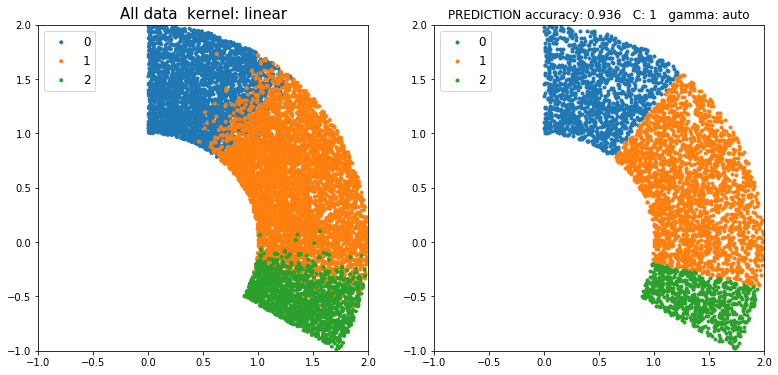

In [12]:
ana.view_data_predict()
'''
do self.visualise_data() and self.view_predict()

''' 

In [13]:
ana.get_boundary_ROC(ana.k01, ana.b01, 0, ana.Xte, ana.tte)
'''
get TPR and FPR for a specific boundary, the boundary depends on the input data

must be linear kernel

k = slope of the boundary
b = bias of the boundary
tar_lab = the label of the boundary, i.e. the points above the boundary is supposed to <= tar_lab
data = test data
label = actual label of test data

'''

'\nget TPR and FPR for a specific boundary, the boundary depends on the input data\n\nmust be linear kernel\n\nk = slope of the boundary\nb = bias of the boundary\ntar_lab = the label of the boundary, i.e. the points above the boundary is supposed to <= tar_lab\ndata = test data\nlabel = actual label of test data\n\n'

In [14]:
ana.getTPR_FPR(ana.b01, 0, ana.Xte, ana.tte)
'''
return list of TPR and list FPR for a bias, the boundary will sweep through the space specified by b and angle(range)

b = bias of boundary
tar_lab = the label of the boundary, i.e. the points above the boundary is supposed to <= tar_lab
data = test data
label = actual label of test data
angle = the range of changing k(default to be (-pi/2, pi/2))

'''

'\nreturn list of TPR and list FPR for a bias, the boundary will sweep through the space specified by b and angle(range)\n\nb = bias of boundary\ntar_lab = the label of the boundary, i.e. the points above the boundary is supposed to <= tar_lab\ndata = test data\nlabel = actual label of test data\nangle = the range of changing k(default to be (-pi/2, pi/2))\n\n'

AUC01: 0.9958577366402214  AUC12: 0.9927931050284989


True

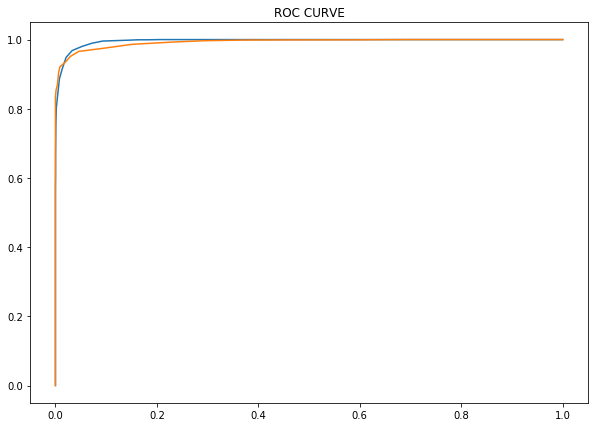

In [20]:
ana.view_ROC_AUC()
'''
view the ROC curves and AUC values of this dataset 

'''

In [21]:
ana.getMiscDis(ana.k01, ana.k12, ana.Xte, ana.tte)
'''
return the average distance from misclassified points to the boundary specified by k and b
for linear classifier

k = slope of the boundary
tar_lab = the label of the boundary, i.e. the points above the boundary is supposed to <= tar_lab
data = test data
label = actual label of test data
bias = bias of the boundary
origin = angle against what origin, default to be (0,0)

'''

(0.06113861424648757, 0.05550261693310593)

In [23]:
ana.show_correctness(ana.Xte)
'''
get correctness label of data(label compared to prediction)

k = slope of the boundary
b = bias of the boundary
tar_lab = the label of the boundary, i.e. the points above the boundary is supposed to <= tar_lab
data = test data
label = actual label of test data
'''

[[[0.98589348, 0.50826621], True],
 [[1.0712129, 0.092490736], True],
 [[1.6525859, -0.2754363], True],
 [[1.6666208, -0.11510887], True],
 [[1.2369964, 0.35959514], True],
 [[0.57738905, 1.7797582], True],
 [[1.1722954, 1.0996405], True],
 [[1.9371277, -0.11096377], True],
 [[0.20218158, 1.1824312], True],
 [[1.091741, 1.0726878], True],
 [[1.4271272, 0.69492864], True],
 [[1.2545044, -0.16138117], True],
 [[1.2471283, 1.1279227], True],
 [[1.1792389, 1.3179762], True],
 [[0.69626195, 1.370035], True],
 [[1.3727131, -0.62230229], True],
 [[0.87361468, 0.90190313], False],
 [[1.6055737, -0.74635574], True],
 [[1.0545521, -0.54135291], True],
 [[1.6425234, 0.35634349], True],
 [[0.45173279, 0.94830761], True],
 [[1.300537, 0.58861205], True],
 [[0.61813319, 1.2073355], True],
 [[0.526216, 1.675902], True],
 [[1.3743098, -0.66188782], True],
 [[1.4436556, 0.45946194], True],
 [[0.84787356, 0.84441906], True],
 [[1.9199423, -0.16878747], True],
 [[1.0971171, 0.89717398], True],
 [[0.69743

True

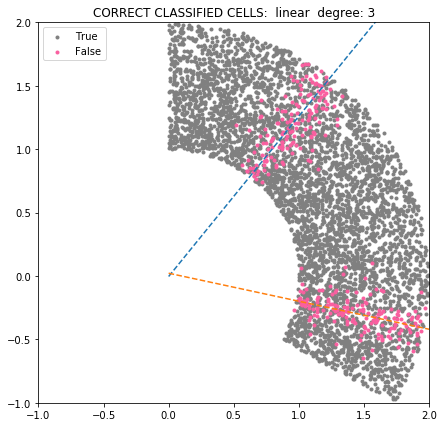

In [24]:
ana.view_correctness()
'''
view the graph with the misclassified points coloured

titile = title of the graph, default='CORRECT CLASSIFIED CELLS'

'''

In [25]:
ana.getTPR_theta(np.linspace(-90, 90, num = 100), ana.Xte, ana.tte, 0)
'''
return list of [theta, TPR], the boundary sweeps through the space based on theta_list, each of them crosses the origin

best for linear kernel

theta_list = thetas of the boundaries
data = test data
label = actual label of test data
tar_lab = the label of the boundary, i.e. the points above the boundary is supposed to <= tar_lab

'''

array([[-9.00000000e+01,  1.00000000e+00],
       [-8.81818182e+01,  1.00000000e+00],
       [-8.63636364e+01,  1.00000000e+00],
       [-8.45454545e+01,  1.00000000e+00],
       [-8.27272727e+01,  1.00000000e+00],
       [-8.09090909e+01,  1.00000000e+00],
       [-7.90909091e+01,  1.00000000e+00],
       [-7.72727273e+01,  1.00000000e+00],
       [-7.54545455e+01,  1.00000000e+00],
       [-7.36363636e+01,  1.00000000e+00],
       [-7.18181818e+01,  1.00000000e+00],
       [-7.00000000e+01,  1.00000000e+00],
       [-6.81818182e+01,  1.00000000e+00],
       [-6.63636364e+01,  1.00000000e+00],
       [-6.45454545e+01,  1.00000000e+00],
       [-6.27272727e+01,  1.00000000e+00],
       [-6.09090909e+01,  1.00000000e+00],
       [-5.90909091e+01,  1.00000000e+00],
       [-5.72727273e+01,  1.00000000e+00],
       [-5.54545455e+01,  1.00000000e+00],
       [-5.36363636e+01,  1.00000000e+00],
       [-5.18181818e+01,  1.00000000e+00],
       [-5.00000000e+01,  1.00000000e+00],
       [-4.

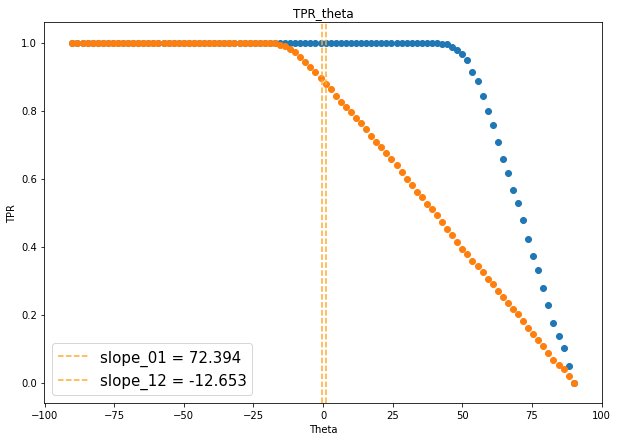

In [26]:
ana.view_TPR_theta()
'''
view TPR against Theta
best for linear kernel

theta_range =  chosen angle of boundaries
'''

In [28]:
ana.TPR_delta_theta(np.linspace(-30, 90, num = 51))
'''
return values for probability distribution(the portion of a label in an area)
best for linear kernel

theta_list = thetas of the boundaries (-90,90)
cell_label = if True, calculate the increasement of True points(actual label) sweep by last move, if False, calculate the False points(actual label)
'''

([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.010101010101010102,
  0.0,
  0.019417475728155338,
  0.034782608695652174,
  0.15178571428571427,
  0.18584070796460178,
  0.39361702127659576,
  0.6631578947368421,
  0.78,
  0.8775510204081632,
  0.9716981132075472,
  0.9801980198019802,
  1.0,
  0.9900990099009901,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [0.0,
  0.0,
  0.008264462809917356,
  0.02564102564102564,
  0.02,
  0.18681318681318682,
  0.24528301886792453,
  0.5087719298245614,
  0.594059405940594,
  0.8865979381443299,
  0.8586956521739131,
  0.9891304347826086,
  0.9813084112149533,
  0.9885057471264368,
  0.9831932773109243,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  

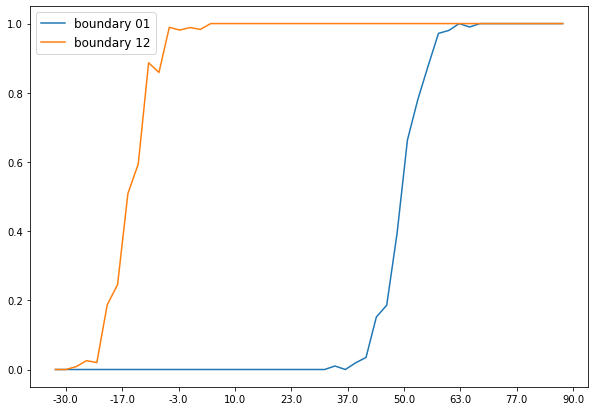

In [29]:
ana.view_TPR_delta_theta()
'''
return values for probability distribution
best for linear kernel

theta_list = thetas of the boundaries (-90,90)
cell_label = if True, calculate the increasement of True points(actual label) sweep by last move, if False, calculate the False points(actual label)
sample = how many samples are chosen to form the curve
title = title of graph
'''

True

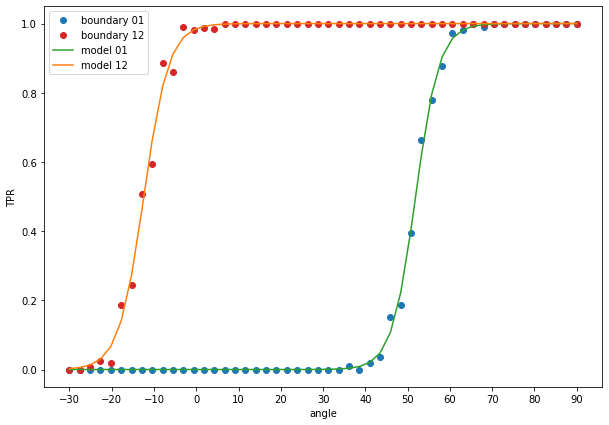

In [58]:
ana.view_boltzmann_model()
''' 
get the TPR against the angle
        
'''

In [87]:
Snm = SharpnessMeasurement('D:/CytonemeSignaling/testDataStudySharpness_linear/NonlinearNonMonotonic')

coords_00001.dat
coords_00002.dat
coords_00003.dat
coords_00004.dat
coords_00005.dat
coords_00006.dat
coords_00007.dat
coords_00008.dat
coords_00009.dat
coords_00010.dat
coords_00011.dat
coords_00012.dat
coords_00013.dat
coords_00014.dat
coords_00015.dat
coords_00016.dat
coords_00017.dat
coords_00018.dat
coords_00019.dat
coords_00020.dat
coords_00021.dat
coords_00022.dat
coords_00023.dat
coords_00024.dat
coords_00025.dat
coords_00026.dat
coords_00027.dat
coords_00028.dat
coords_00029.dat
coords_00030.dat
coords_00031.dat
coords_00032.dat
coords_00033.dat
coords_00034.dat
coords_00035.dat
coords_00036.dat
coords_00037.dat
coords_00038.dat
coords_00039.dat
coords_00040.dat
coords_00041.dat
coords_00042.dat
coords_00043.dat
coords_00044.dat
coords_00045.dat
coords_00046.dat
coords_00047.dat
coords_00048.dat
coords_00049.dat
coords_00050.dat
coords_00051.dat
coords_00052.dat
coords_00053.dat
coords_00054.dat
coords_00055.dat
coords_00056.dat
coords_00057.dat
coords_00058.dat
coords_00059.d

'\nshow b of Boltzmann\n\ngraph = show the graph or not\ntitle = title\nxlist = default to be linear x\n\n'

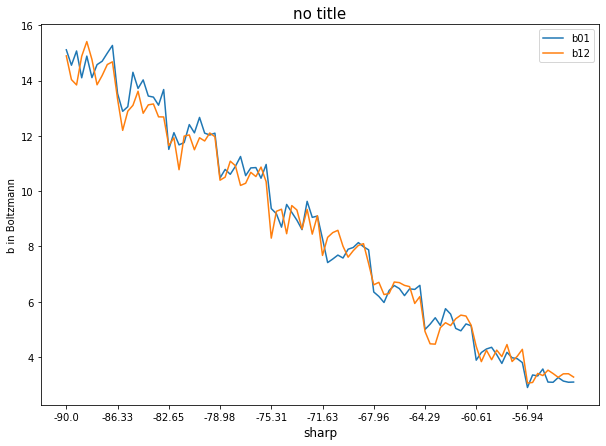

In [88]:
Snm.b_of_Boltzmann()
'''
show b of Boltzmann

graph = show the graph or not
title = title
xlist = default to be linear x

'''

coords_00001.dat
coords_00002.dat
coords_00003.dat
coords_00004.dat
coords_00005.dat
coords_00006.dat
coords_00007.dat
coords_00008.dat
coords_00009.dat
coords_00010.dat
coords_00011.dat
coords_00012.dat
coords_00013.dat
coords_00014.dat
coords_00015.dat
coords_00016.dat
coords_00017.dat
coords_00018.dat
coords_00019.dat
coords_00020.dat
coords_00021.dat
coords_00022.dat
coords_00023.dat
coords_00024.dat
coords_00025.dat
coords_00026.dat
coords_00027.dat
coords_00028.dat
coords_00029.dat
coords_00030.dat
coords_00031.dat
coords_00032.dat
coords_00033.dat
coords_00034.dat
coords_00035.dat
coords_00036.dat
coords_00037.dat
coords_00038.dat
coords_00039.dat
coords_00040.dat
coords_00041.dat
coords_00042.dat
coords_00043.dat
coords_00044.dat
coords_00045.dat
coords_00046.dat
coords_00047.dat
coords_00048.dat
coords_00049.dat
coords_00050.dat
coords_00051.dat
coords_00052.dat
coords_00053.dat
coords_00054.dat
coords_00055.dat
coords_00056.dat
coords_00057.dat
coords_00058.dat
coords_00059.d

' describe the sharpness of the document with AUC \n        \n    graph = show the graph or not\n    title = title of the graph\n    xlist = the xlist specified for the graph\n'

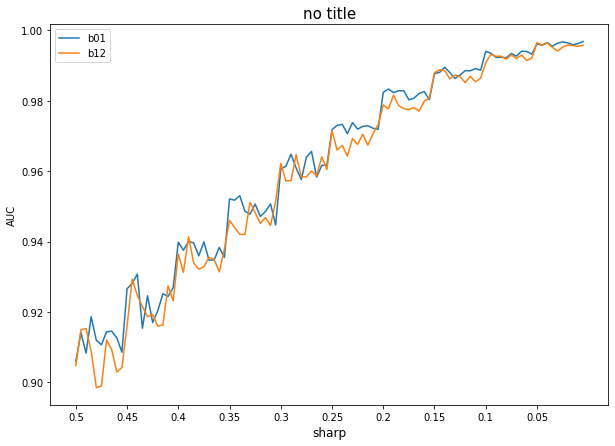

In [89]:
Snm.AUC()
''' describe the sharpness of the document with AUC 
        
    graph = show the graph or not
    title = title of the graph
    xlist = the xlist specified for the graph
'''

coords_00001.dat
coords_00002.dat
coords_00003.dat
coords_00004.dat
coords_00005.dat
coords_00006.dat
coords_00007.dat
coords_00008.dat
coords_00009.dat
coords_00010.dat
coords_00011.dat
coords_00012.dat
coords_00013.dat
coords_00014.dat
coords_00015.dat
coords_00016.dat
coords_00017.dat
coords_00018.dat
coords_00019.dat
coords_00020.dat
coords_00021.dat
coords_00022.dat
coords_00023.dat
coords_00024.dat
coords_00025.dat
coords_00026.dat
coords_00027.dat
coords_00028.dat
coords_00029.dat
coords_00030.dat
coords_00031.dat
coords_00032.dat
coords_00033.dat
coords_00034.dat
coords_00035.dat
coords_00036.dat
coords_00037.dat
coords_00038.dat
coords_00039.dat
coords_00040.dat
coords_00041.dat
coords_00042.dat
coords_00043.dat
coords_00044.dat
coords_00045.dat
coords_00046.dat
coords_00047.dat
coords_00048.dat
coords_00049.dat
coords_00050.dat
coords_00051.dat
coords_00052.dat
coords_00053.dat
coords_00054.dat
coords_00055.dat
coords_00056.dat
coords_00057.dat
coords_00058.dat
coords_00059.d

' describe the sharpness of the document with angular distance or raw distance \n            \n    graph = show the graph or not\n    title = title of the graph\n    xlist = the xlist specified for the graph\n    augular = use augualr distance or raw distance\n'

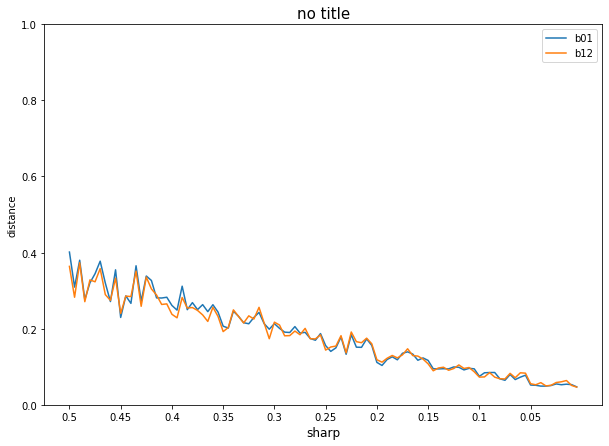

In [90]:
Snm.distance(angular = True)
''' describe the sharpness of the document with angular distance or raw distance 
            
    graph = show the graph or not
    title = title of the graph
    xlist = the xlist specified for the graph
    augular = use augualr distance or raw distance
'''

coords_00001.dat
coords_00002.dat
coords_00003.dat
coords_00004.dat
coords_00005.dat
coords_00006.dat
coords_00007.dat
coords_00008.dat
coords_00009.dat
coords_00010.dat
coords_00011.dat
coords_00012.dat
coords_00013.dat
coords_00014.dat
coords_00015.dat
coords_00016.dat
coords_00017.dat
coords_00018.dat
coords_00019.dat
coords_00020.dat
coords_00021.dat
coords_00022.dat
coords_00023.dat
coords_00024.dat
coords_00025.dat
coords_00026.dat
coords_00027.dat
coords_00028.dat
coords_00029.dat
coords_00030.dat
coords_00031.dat
coords_00032.dat
coords_00033.dat
coords_00034.dat
coords_00035.dat
coords_00036.dat
coords_00037.dat
coords_00038.dat
coords_00039.dat
coords_00040.dat
coords_00041.dat
coords_00042.dat
coords_00043.dat
coords_00044.dat
coords_00045.dat
coords_00046.dat
coords_00047.dat
coords_00048.dat
coords_00049.dat
coords_00050.dat
coords_00051.dat
coords_00052.dat
coords_00053.dat
coords_00054.dat
coords_00055.dat
coords_00056.dat
coords_00057.dat
coords_00058.dat
coords_00059.d

' describe the sharpness of the document with angular distance or raw distance \n            \n    graph = show the graph or not\n    title = title of the graph\n    xlist = the xlist specified for the graph\n    augular = use augualr distance or raw distance\n'

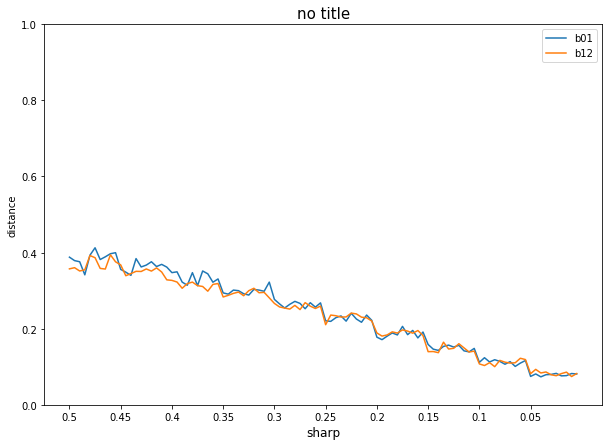

In [91]:
Snm.distance(angular = False)
''' describe the sharpness of the document with angular distance or raw distance 
            
    graph = show the graph or not
    title = title of the graph
    xlist = the xlist specified for the graph
    augular = use augualr distance or raw distance
'''

coords_00001.dat
coords_00002.dat
coords_00003.dat
coords_00004.dat
coords_00005.dat
coords_00006.dat
coords_00007.dat
coords_00008.dat
coords_00009.dat
coords_00010.dat
coords_00011.dat
coords_00012.dat
coords_00013.dat
coords_00014.dat
coords_00015.dat
coords_00016.dat
coords_00017.dat
coords_00018.dat
coords_00019.dat
coords_00020.dat
coords_00021.dat
coords_00022.dat
coords_00023.dat
coords_00024.dat
coords_00025.dat
coords_00026.dat
coords_00027.dat
coords_00028.dat
coords_00029.dat
coords_00030.dat
coords_00031.dat
coords_00032.dat
coords_00033.dat
coords_00034.dat
coords_00035.dat
coords_00036.dat
coords_00037.dat
coords_00038.dat
coords_00039.dat
coords_00040.dat
coords_00041.dat
coords_00042.dat
coords_00043.dat
coords_00044.dat
coords_00045.dat
coords_00046.dat
coords_00047.dat
coords_00048.dat
coords_00049.dat
coords_00050.dat
coords_00051.dat
coords_00052.dat
coords_00053.dat
coords_00054.dat
coords_00055.dat
coords_00056.dat
coords_00057.dat
coords_00058.dat
coords_00059.d

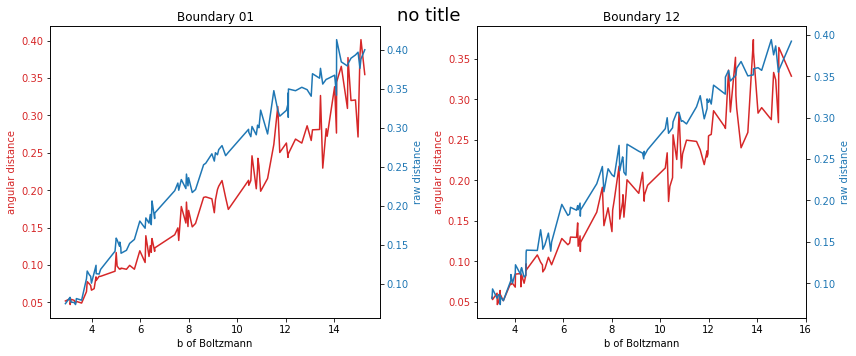

' show the sharpness described by distance against that by Boltzmann \n        \n    graph = show the graph or not\n    title = title of the graph\n    xlist = the xlist specified for the graph\n'

In [92]:
Snm.distance_against_Boltzmann()
''' show the sharpness described by distance against that by Boltzmann 
        
    graph = show the graph or not
    title = title of the graph
    xlist = the xlist specified for the graph
'''

In [97]:
# retrieve the memory
del Snm
gc.collect()

853